In [2]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, string, os
import gensim, spacy, glove
import sent2vec

from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from scipy import linalg, mat, dot
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.wrappers import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Train models using billion words corpus data (implement once)

In [2]:
# Save UTF-8 version of text corpus for training

billwords_raw = open("/project/1-billion-word-language-modeling-benchmark-r13output.tar", "r", encoding="ISO-8859-1")
billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'w')

translator = str.maketrans("", "", string.punctuation)

for i, line in enumerate(billwords_raw):
    if i==0:
        pos = line.find("While")
        line = line[pos:]
    if '\0' in line:
        line = line.replace('\0', '')
        
    line = line.translate(translator)
    line = line.lower().strip()
    billwords_clean.write(line)
    billwords_clean.write('\n')                

billwords_raw.close()
billwords_clean.close()

In [ ]:
if '\0' in open('/project/paragraph-vectors/data/billwords_preprocessed.csv').read():
    print("you have null bytes in your input file")
else:
    print ("you don't")

In [ ]:
# Save CSV version of text corpus for training

billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'r')
billwords_csv = open('/project/paragraph-vectors/data/billwords_preprocessed.csv', 'w')

billwords_csv.write('text')
billwords_csv.write('\n')

translator = str.maketrans("", "", string.punctuation)

for line in billwords_clean:
    billwords_csv.write(line)
    billwords_csv.write('\n')

billwords_clean.close()
billwords_csv.close()

In [2]:
# Save CSV version of text corpus for training

billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'r')
billwords_sample = open('/project/sample_billwords/billwords_sample.txt', 'w')

translator = str.maketrans("", "", string.punctuation)

for i, line in enumerate(billwords_clean):
    if i == 25000000:
        break
    if '\0' in line:
        line = line.replace('\0', '')
    line = line.translate(translator)
    line = line.lower().strip()
    billwords_sample.write(line)
    billwords_sample.write('\n')

billwords_clean.close()
billwords_sample.close()

In [ ]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            translator = str.maketrans("", "", string.punctuation)
            for line in open(os.path.join(self.dirname, fname)):
                line = line.translate(translator)
                line = line.lower().strip()
                yield line.split()

# Assign documents to directory of dataset for training
documents = MySentences("/project/billion_words_dataset")

In [ ]:
# Train word2vec models

modelwd_cbow = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, sg=0)
modelwd_sg = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, sg=1)
#modelwd_train.train(documents, total_examples=len(documents), epochs=20)

In [ ]:
# Save word2vec models

modelwd_cbow.wv.save_word2vec_format('modelwd_cbow.bin', binary=True)
modelwd_sg.wv.save_word2vec_format('modelwd_sg.bin', binary=True)

In [ ]:
# Train GloVe model using dataset assigned to documents
documents = MySentences("/project/billion_words_dataset")

corpus = Corpus()
corpus.fit(documents, window=5)
 
modelgl_train = Glove(no_components=300, learning_rate=0.05)

# Train model with epochs
modelgl_train.fit(corpus.matrix, epochs=5, no_threads=20, verbose=True)

# Add word embeddings to corpus dictionary
modelgl_train.add_dictionary(corpus.dictionary)

# Save model
modelgl_train.save('modelgl_train.txt')

In [ ]:
# Run fastText models in Terminal

./fasttext skipgram -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr 0.025 -output modelft_sg

./fasttext cbow -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr 0.05 -output modelft_cbow

In [ ]:
# Run sent2vec models in Terminal

./fasttext sent2vec -input billwords_preprocessed.txt -output modelsn_uni -minCount 5 -dim 300 -epoch 5 -lr 0.2 -wordNgrams 1 -loss ns -neg 5 -thread 20

./fasttext sent2vec -input billwords_preprocessed.txt -output modelsn_bi -minCount 5 -dim 300 -epoch 5 -lr 0.2 -wordNgrams 2 -loss ns -neg 5 -thread 20

In [ ]:
python train.py start --data_file_name 'billwords_preprocessed.csv' --num_epochs 5 --batch_size 32 --num_noise_words 2 --vec_dim 300 --lr 0.025 --context_size 5 --model_ver 'dm' --num_workers 20

## Data preparation and munging

In [12]:
# Load datasets

sick = open("SICK.txt", "r")
msr1 = open("msr_train.txt", "r")
msr2 = open("msr_test.txt", "r")
#ppdb = open("ppdb-2.0-l-all", "r")

In [13]:
def read_text_file(file):
    
    '''Reads lines in file and appends to a corpus list'''
    
    corpus = []
    for i, line in enumerate(file):
        if i==0:
            continue
        else:
            corpus.append(line)
    
    return corpus

In [14]:
def read_more_files(file1, file2=None):
    
    '''Reads lines in two files and appends them to a corpus list'''
    
    if file2==None:
        corpus = read_text_file(file1)
        
    else:
        corpus1 = read_text_file(file1)
        corpus2 = read_text_file(file2)
        corpus = corpus1 + corpus2
    
    print(len(corpus))
    return corpus   

In [15]:
# Implementation

sick_corpus = read_more_files(sick)
sick_corpus

9840


['1\tA group of kids is playing in a yard and an old man is standing in the background\tA group of boys in a yard is playing and a man is standing in the background\tNEUTRAL\t4.5\tA_neutral_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '2\tA group of children is playing in the house and there is no man standing in the background\tA group of kids is playing in a yard and an old man is standing in the background\tNEUTRAL\t3.2\tA_contradicts_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '3\tThe young boys are playing outdoors and the man is smiling nearby\tThe kids are playing outdoors near a man with a smile\tENTAILMENT\t4.7\tA_entails_B\tB_entails_A\tThe children are playing outdoors, while a man smiles nearby.\tThe children are playing 

In [16]:
# Implementation

msr_corpus = read_more_files(msr1, msr2)
msr_corpus

5801


['1\t702876\t702977\tAmrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.\tReferring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.\n',
 "0\t2108705\t2108831\tYucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.\tYucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.\n",
 "1\t1330381\t1330521\tThey had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.\tOn June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.\n",
 '0\t3344667\t3344648\tAround 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.\tTab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.\n',
 '1\t1236820\t1236712\tThe stock rose $2.11, or about 11 percent, to close Friday at $21.51 on

In [17]:
def extract_sentences_scores(corpus):
    
    '''Creates a list of sentence pairs omitting punctuation and a list of similarity scores'''
    
    sentences, scores = [], []
    for line in corpus:
        words = line.split('\t')
        
        for i, word in enumerate(words):
            try:
                int(word[0])
                continue
                
            except:
                sent1 = words[i].lower().strip()
                sent2 = words[i+1].lower().strip()
                
                translator = str.maketrans("", "", string.punctuation)
                sent1 = sent1.translate(translator)
                sent2 = sent2.translate(translator)
                
                sentences.append([sent1, sent2])
                
                if i==1:
                    score = words[4]
                    scores.append(float(score))
                
                elif i==3:
                    score = words[0]
                    scores.append(float(score))
                
                break
            
            else: continue
        
    return sentences, scores

In [18]:
# Implementation

sick_sentences, sick_scores = extract_sentences_scores(sick_corpus)
msr_sentences, msr_scores = extract_sentences_scores(msr_corpus)

In [ ]:
sick_sentences

In [ ]:
msr_sentences

## Stemming, Lemmatization, Filtering stopwords

In [19]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def stemming_words(sentences):
    
    '''Stems words in sentences using Porter Stemmer'''
    
    porter_stemmer = PorterStemmer()
    
    sentences_stem = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                sent_new.append(porter_stemmer.stem(word))
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_stem.append(pair_new)
    
    return sentences_stem
        

In [20]:
# Implementation

sick_sentences_stem = stemming_words(sick_sentences)
msr_sentences_stem = stemming_words(msr_sentences)

In [ ]:
sick_sentences_stem

In [ ]:
msr_sentences_stem

In [21]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    '''Gets POS tags from Wordnet'''
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''
    

In [22]:
from nltk import pos_tag

def pos_tagging(sentences):
    
    '''Part-of-Speech tagging using Wordnet treebank tags'''
    
    sentences_pos = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            tagged = pos_tag(words)
            for token, tag in tagged:
                wntag = get_wordnet_pos(tag)
                wordset = (token, wntag)
                sent_new.append(wordset)
            pair_new.append(sent_new) 
        sentences_pos.append(pair_new)
    
    return sentences_pos

In [23]:
# Implementation

sick_sentences_pos = pos_tagging(sick_sentences)
msr_sentences_pos = pos_tagging(msr_sentences)

In [ ]:
sick_sentences_pos

In [ ]:
msr_sentences_pos

In [24]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatizing_words(sentences):
    
    '''Lemmatizes words in sentences that are POS-tagged'''
    
    sentences_pos = pos_tagging(sentences)
    
    lemmatizer = WordNetLemmatizer()
    
    sentences_lemma = []
    for pair in sentences_pos:
        pair_new = []
        for sent in pair:
            sent_new = []
            for wordset in sent:
                try:
                    sent_new.append(lemmatizer.lemmatize(wordset[0], pos=wordset[1]))
                except:
                    sent_new.append(wordset[0])
                doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_lemma.append(pair_new)
    
    return sentences_lemma

In [25]:
# Implementation

sick_sentences_lemma = lemmatizing_words(sick_sentences)
msr_sentences_lemma = lemmatizing_words(msr_sentences)

In [ ]:
sick_sentences_lemma

In [ ]:
msr_sentences_lemma

In [26]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
    
def remove_stopwords(sentences, stopwords):
    
    '''Removes English stopwords from sentences'''
    
    filtered_words = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                if word not in stopwords:
                    sent_new.append(word)
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        filtered_words.append(pair_new)
    
    return filtered_words

In [27]:
# Implementation

sick_filtered = remove_stopwords(sick_sentences_lemma, stopwords)
msr_filtered = remove_stopwords(msr_sentences_lemma, stopwords)

In [ ]:
sick_filtered

In [ ]:
msr_filtered

## Functions for model evaluation

In [28]:
def convert_scores_to_binary(scores_list, threshold):
    
    '''Converts a percentage accuracy score to either a 0 or a 1'''
    
    bin_scores = []
    for score in scores_list:
        if score < threshold:
            bin_scores.append(0)
        else:
            bin_scores.append(1)
    
    return bin_scores

msr_scores = convert_scores_to_binary(msr_scores, 0.7)

In [29]:
def create_correlation_tables(df):
    
    '''Creates tables showing Pearson's and Spearman's correlations'''
    
    
    display(df.corr(method='pearson'))
    print("Pearson's correlation")
    
    display(df.corr(method='spearman'))
    print("Spearman's correlation")
    
    return

In [30]:
def create_confusion_matrices(df):
    
    '''Creates confusion matrices with accuracy and F1 scores'''
    
    for column in df:
        cf = pd.DataFrame(confusion_matrix(df['Similarity'], df[column]), 
                          columns=['True 0', 'True 1'], index=['Pred 0', 'Pred 1'])
        cf.index.name = column
        display(cf)
        
        acc = accuracy_score(df['Similarity'], df[column])
        f1 = f1_score(df['Similarity'], df[column])
        print('Accuracy:', round(acc, 6))
        print('F1 score:', round(f1, 6))
        
    return

## Bag-of-Words model

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

def run_bow_model(sentences):
    
    '''Creates BoW model and calculates cosine similarity of each sentence pair'''
    
    scores_list = []
    ngrams = [(1, 1), (1, 2)]
    
    for tup in ngrams:
        count_vec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=tup, 
                                   max_df=1.0, min_df=0.5, max_features=None)
        
        bow_scores = []  
        for pair in sentences:
            bow_model = count_vec.fit_transform(pair).toarray()  
            cos_sim = cosine_similarity(bow_model[0,:].reshape(1,-1), bow_model[1,:].reshape(1, -1))
            bow_scores.append(float(cos_sim))
        
        scores_list.append(bow_scores)
        
    
    return scores_list

In [22]:
# Implementation

sick_bow_scores = run_bow_model(sick_sentences)
msr_bow_scores = run_bow_model(msr_sentences)

sick_bow_stem_scores = run_bow_model(sick_sentences_stem)
msr_bow_stem_scores = run_bow_model(msr_sentences_stem)

sick_bow_lem_scores = run_bow_model(sick_sentences_lemma)
msr_bow_lem_scores = run_bow_model(msr_sentences_lemma)

sick_bow_stw_scores = run_bow_model(sick_filtered)
msr_bow_stw_scores = run_bow_model(msr_filtered)

In [ ]:
sick_bow_scores

In [ ]:
msr_bow_scores

In [23]:
df_sick_bow = pd.DataFrame({'Relatedness': sick_scores, 'BoW_uni': sick_bow_scores[0], 'BoW_bi': sick_bow_scores[1],
                            'BoW_stem_uni': sick_bow_stem_scores[0], 'BoW_stem_bi': sick_bow_stem_scores[1],
                            'BoW_lemma_uni': sick_bow_lem_scores[0], 'BoW_lemma_bi': sick_bow_lem_scores[1], 
                            'BoW_stw_uni': sick_bow_stw_scores[0], 'BoW_stw_bi': sick_bow_stw_scores[1]})
df_sick_bow

,Relatedness,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
0,4.500,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892
1,3.200,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280
2,4.700,0.462910,0.334497,0.617213,0.501745,0.617213,0.501745,0.617213,0.501745
3,3.600,0.676123,0.647150,0.845154,0.832050,0.676123,0.554700,0.676123,0.554700
4,3.400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400
5,3.300,0.316228,0.172133,0.316228,0.172133,0.158114,0.086066,0.158114,0.086066
6,3.700,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769
7,3.000,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846
8,3.700,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223
9,4.900,0.925820,0.836242,0.935414,0.859338,0.925820,0.836242,0.925820,0.836242


In [24]:
# Implementation

create_correlation_tables(df_sick_bow)

,Relatedness,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
Relatedness,1.000000,0.614472,0.545892,0.638548,0.568393,0.640159,0.569404,0.640185,0.569422
BoW_uni,0.614472,1.000000,0.958149,0.955107,0.939965,0.948546,0.932975,0.948555,0.932983
BoW_bi,0.545892,0.958149,1.000000,0.902237,0.972989,0.895042,0.965416,0.895041,0.965419
BoW_stem_uni,0.638548,0.955107,0.902237,1.000000,0.948579,0.982421,0.931857,0.982429,0.931864
BoW_stem_bi,0.568393,0.939965,0.972989,0.948579,1.000000,0.931565,0.981616,0.931563,0.981618
BoW_lemma_uni,0.640159,0.948546,0.895042,0.982421,0.931565,1.000000,0.947317,0.999999,0.947319
BoW_lemma_bi,0.569404,0.932975,0.965416,0.931857,0.981616,0.947317,1.000000,0.947311,0.999999
BoW_stw_uni,0.640185,0.948555,0.895041,0.982429,0.931563,0.999999,0.947311,1.000000,0.947315
BoW_stw_bi,0.569422,0.932983,0.965419,0.931864,0.981618,0.947319,0.999999,0.947315,1.000000


Pearson's correlation


,Relatedness,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
Relatedness,1.000000,0.556966,0.548808,0.574967,0.560434,0.581296,0.563330,0.581319,0.563354
BoW_uni,0.556966,1.000000,0.976928,0.948693,0.952580,0.940597,0.944389,0.940604,0.944397
BoW_bi,0.548808,0.976928,1.000000,0.916940,0.971279,0.909686,0.964409,0.909689,0.964414
BoW_stem_uni,0.574967,0.948693,0.916940,1.000000,0.960386,0.978701,0.942494,0.978707,0.942501
BoW_stem_bi,0.560434,0.952580,0.971279,0.960386,1.000000,0.942981,0.982938,0.942983,0.982943
BoW_lemma_uni,0.581296,0.940597,0.909686,0.978701,0.942981,1.000000,0.959520,0.999999,0.959520
BoW_lemma_bi,0.563330,0.944389,0.964409,0.942494,0.982938,0.959520,1.000000,0.959516,0.999999
BoW_stw_uni,0.581319,0.940604,0.909689,0.978707,0.942983,0.999999,0.959516,1.000000,0.959519
BoW_stw_bi,0.563354,0.944397,0.964414,0.942501,0.982943,0.959520,0.999999,0.959519,1.000000


Spearman's correlation


In [25]:
# Convert scores to binary

msr_bow_binscores, msr_bow_stem_binscores, msr_bow_lem_binscores, msr_bow_stw_binscores = [], [], [], []
threshold = 0.7

for i in range(0, 2):
    msr_bow_binscores.append(convert_scores_to_binary(msr_bow_scores[i], threshold))
    msr_bow_stem_binscores.append(convert_scores_to_binary(msr_bow_stem_scores[i], threshold))
    msr_bow_lem_binscores.append(convert_scores_to_binary(msr_bow_lem_scores[i], threshold))
    msr_bow_stw_binscores.append(convert_scores_to_binary(msr_bow_stw_scores[i], threshold))

In [26]:
df_msr_bow = pd.DataFrame({'Similarity': msr_scores, 'BoW_uni': msr_bow_binscores[0], 'BoW_bi': msr_bow_binscores[1],
                            'BoW_stem_uni': msr_bow_stem_binscores[0], 'BoW_stem_bi': msr_bow_stem_binscores[1],
                            'BoW_lemma_uni': msr_bow_lem_binscores[0], 'BoW_lemma_bi': msr_bow_lem_binscores[1], 
                            'BoW_stw_uni': msr_bow_stw_binscores[0], 'BoW_stw_bi': msr_bow_stw_binscores[1]})
df_msr_bow

,Similarity,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0
5,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,1,0


In [27]:
# Implementation

create_confusion_matrices(df_msr_bow)

,True 0,True 1
Similarity,,
Pred 0,1901,0
Pred 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,True 0,True 1
BoW_uni,,
Pred 0,1479,422
Pred 1,1750,2150


Accuracy: 0.625582
F1 score: 0.6644


,True 0,True 1
BoW_bi,,
Pred 0,1723,178
Pred 1,2682,1218


Accuracy: 0.506982
F1 score: 0.45997


,True 0,True 1
BoW_stem_uni,,
Pred 0,1425,476
Pred 1,1550,2350


Accuracy: 0.65075
F1 score: 0.698781


,True 0,True 1
BoW_stem_bi,,
Pred 0,1692,209
Pred 1,2522,1378


Accuracy: 0.529219
F1 score: 0.502278


,True 0,True 1
BoW_lemma_uni,,
Pred 0,1449,452
Pred 1,1603,2297


Accuracy: 0.645751
F1 score: 0.690931


,True 0,True 1
BoW_lemma_bi,,
Pred 0,1695,206
Pred 1,2552,1348


Accuracy: 0.524565
F1 score: 0.494316


,True 0,True 1
BoW_stw_uni,,
Pred 0,1446,455
Pred 1,1604,2296


Accuracy: 0.645061
F1 score: 0.690422


,True 0,True 1
BoW_stw_bi,,
Pred 0,1695,206
Pred 1,2548,1352


Accuracy: 0.525254
F1 score: 0.49542


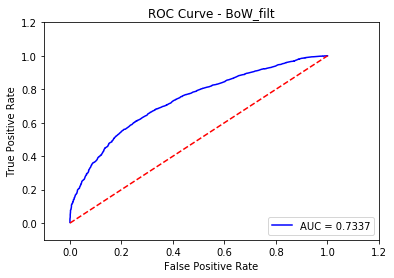

In [28]:
# ROC curve and AUC score

plt.figure(figsize=(6, 4))
# ROC curve; AUC score
fpr, tpr, thresholds = roc_curve(msr_scores, msr_bow_stw_scores[0], pos_label=1)
roc_auc_dt = auc(fpr, tpr)

plt.title('ROC Curve - BoW_filt')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.4f'% roc_auc_dt)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## TF-IDF model

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

def run_tfidf_model(sentences):
    
    '''Creates TF-IDF model and calculates cosine similarity of each sentence pair'''
    
    scores_list = []
    ngrams = [(1, 1), (1, 2)]
    
    for tup in ngrams:
        tfidf_vec = TfidfVectorizer(stop_words="english", analyzer='word', ngram_range=tup, 
                                    max_df=1.0, min_df=0.5, max_features=None)
    
        tfidf_scores = []
        for pair in sentences:
            tfidf_model = tfidf_vec.fit_transform(pair).toarray()
            cos_sim = cosine_similarity(tfidf_model[0,:].reshape(1,-1), tfidf_model[1,:].reshape(1, -1))
            tfidf_scores.append(float(cos_sim))
            
        scores_list.append(tfidf_scores)
           
    return scores_list

In [30]:
# Implementation

sick_tfidf_scores = run_tfidf_model(sick_sentences)
msr_tfidf_scores = run_tfidf_model(msr_sentences)

sick_tfidf_stem_scores = run_tfidf_model(sick_sentences_stem)
msr_tfidf_stem_scores = run_tfidf_model(msr_sentences_stem)

sick_tfidf_lem_scores = run_tfidf_model(sick_sentences_lemma)
msr_tfidf_lem_scores = run_tfidf_model(msr_sentences_lemma)

sick_tfidf_stw_scores = run_tfidf_model(sick_filtered)
msr_tfidf_stw_scores = run_tfidf_model(msr_filtered)

In [ ]:
sick_tfidf_scores

In [ ]:
msr_tfidf_scores

In [31]:
df_sick_tfidf = pd.DataFrame({'Relatedness': sick_scores, 'TF-IDF_uni': sick_tfidf_scores[0], 'TF-IDF_bi': sick_tfidf_scores[1],
                            'TF-IDF_stem_uni': sick_tfidf_stem_scores[0], 'TF-IDF_stem_bi': sick_tfidf_stem_scores[1],
                            'TF-IDF_lemma_uni': sick_tfidf_lem_scores[0], 'TF-IDF_lemma_bi': sick_tfidf_lem_scores[1], 
                            'TF-IDF_stw_uni': sick_tfidf_stw_scores[0], 'TF-IDF_stw_bi': sick_tfidf_stw_scores[1]})
df_sick_tfidf

,Relatedness,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
0,4.500,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992
1,3.200,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619
2,4.700,0.304126,0.203006,0.450268,0.338174,0.450268,0.338174,0.450268,0.338174
3,3.600,0.519388,0.487191,0.747407,0.729728,0.519388,0.390186,0.519388,0.390186
4,3.400,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771
5,3.300,0.190874,0.095554,0.190874,0.095554,0.087044,0.045574,0.087044,0.045574
6,3.700,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849
7,3.000,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286
8,3.700,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040
9,4.900,0.867364,0.724107,0.883128,0.758156,0.867364,0.724107,0.867364,0.724107


In [32]:
# Implementation

create_correlation_tables(df_sick_tfidf)

,Relatedness,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
Relatedness,1.000000,0.560429,0.472194,0.588698,0.493539,0.592724,0.494923,0.592746,0.494934
TF-IDF_uni,0.560429,1.000000,0.949001,0.945470,0.932648,0.935472,0.923116,0.935479,0.923121
TF-IDF_bi,0.472194,0.949001,1.000000,0.877722,0.974425,0.868492,0.965412,0.868492,0.965413
TF-IDF_stem_uni,0.588698,0.945470,0.877722,1.000000,0.925765,0.975357,0.903558,0.975363,0.903561
TF-IDF_stem_bi,0.493539,0.932648,0.974425,0.925765,1.000000,0.903386,0.976208,0.903386,0.976209
TF-IDF_lemma_uni,0.592724,0.935472,0.868492,0.975357,0.903386,1.000000,0.923432,0.999999,0.923432
TF-IDF_lemma_bi,0.494923,0.923116,0.965412,0.903558,0.976208,0.923432,1.000000,0.923429,1.000000
TF-IDF_stw_uni,0.592746,0.935479,0.868492,0.975363,0.903386,0.999999,0.923429,1.000000,0.923430
TF-IDF_stw_bi,0.494934,0.923121,0.965413,0.903561,0.976209,0.923432,1.000000,0.923430,1.000000


Pearson's correlation


,Relatedness,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
Relatedness,1.000000,0.558943,0.548133,0.575866,0.559361,0.581774,0.561944,0.581792,0.561968
TF-IDF_uni,0.558943,1.000000,0.975484,0.949951,0.950735,0.942335,0.942905,0.942341,0.942914
TF-IDF_bi,0.548133,0.975484,1.000000,0.917617,0.971182,0.911414,0.964537,0.911417,0.964542
TF-IDF_stem_uni,0.575866,0.949951,0.917617,1.000000,0.960206,0.978559,0.942262,0.978564,0.942269
TF-IDF_stem_bi,0.559361,0.950735,0.971182,0.960206,1.000000,0.943346,0.982808,0.943348,0.982812
TF-IDF_lemma_uni,0.581774,0.942335,0.911414,0.978559,0.943346,1.000000,0.959869,0.999999,0.959870
TF-IDF_lemma_bi,0.561944,0.942905,0.964537,0.942262,0.982808,0.959869,1.000000,0.959866,0.999999
TF-IDF_stw_uni,0.581792,0.942341,0.911417,0.978564,0.943348,0.999999,0.959866,1.000000,0.959869
TF-IDF_stw_bi,0.561968,0.942914,0.964542,0.942269,0.982812,0.959870,0.999999,0.959869,1.000000


Spearman's correlation


In [33]:
# Convert scores to binary

msr_tfidf_binscores, msr_tfidf_stem_binscores, msr_tfidf_lem_binscores, msr_tfidf_stw_binscores = [], [], [], []
threshold = 0.7

for i in range(0, 2):
    msr_tfidf_binscores.append(convert_scores_to_binary(msr_tfidf_scores[i], threshold))
    msr_tfidf_stem_binscores.append(convert_scores_to_binary(msr_tfidf_stem_scores[i], threshold))
    msr_tfidf_lem_binscores.append(convert_scores_to_binary(msr_tfidf_lem_scores[i], threshold))
    msr_tfidf_stw_binscores.append(convert_scores_to_binary(msr_tfidf_stw_scores[i], threshold))

In [34]:
df_msr_tfidf = pd.DataFrame({'Similarity': msr_scores, 'TF-IDF_uni': msr_tfidf_binscores[0], 'TF-IDF_bi': msr_tfidf_binscores[1],
                            'TF-IDF_stem_uni': msr_tfidf_stem_binscores[0], 'TF-IDF_stem_bi': msr_tfidf_stem_binscores[1],
                            'TF-IDF_lemma_uni': msr_tfidf_lem_binscores[0], 'TF-IDF_lemma_bi': msr_tfidf_lem_binscores[1], 
                            'TF-IDF_stw_uni': msr_tfidf_stw_binscores[0], 'TF-IDF_stw_bi': msr_tfidf_stw_binscores[1]})
df_msr_tfidf

,Similarity,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
0,1,1,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0
5,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,1,0,1,0


In [35]:
# Implementation

create_confusion_matrices(df_msr_tfidf)

,True 0,True 1
Similarity,,
Pred 0,1901,0
Pred 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,True 0,True 1
TF-IDF_uni,,
Pred 0,1795,106
Pred 1,2928,972


Accuracy: 0.476987
F1 score: 0.390518


,True 0,True 1
TF-IDF_bi,,
Pred 0,1866,35
Pred 1,3561,339


Accuracy: 0.380107
F1 score: 0.158634


,True 0,True 1
TF-IDF_stem_uni,,
Pred 0,1783,118
Pred 1,2699,1201


Accuracy: 0.514394
F1 score: 0.460241


,True 0,True 1
TF-IDF_stem_bi,,
Pred 0,1864,37
Pred 1,3469,431


Accuracy: 0.395621
F1 score: 0.197344


,True 0,True 1
TF-IDF_lemma_uni,,
Pred 0,1767,134
Pred 1,2747,1153


Accuracy: 0.503361
F1 score: 0.444573


,True 0,True 1
TF-IDF_lemma_bi,,
Pred 0,1860,41
Pred 1,3464,436


Accuracy: 0.395794
F1 score: 0.199223


,True 0,True 1
TF-IDF_stw_uni,,
Pred 0,1767,134
Pred 1,2742,1158


Accuracy: 0.504223
F1 score: 0.446071


,True 0,True 1
TF-IDF_stw_bi,,
Pred 0,1860,41
Pred 1,3464,436


Accuracy: 0.395794
F1 score: 0.199223


## Functions for model execution

In [31]:
def create_words_list(sentences):
    
    '''Creates a list with separate words in each sentence'''
    
    words_list = []

    for pair in sentences:
        pair_new = []
        for sent in pair:
            words = sent.split()
            pair_new.append(words)

        words_list.append(pair_new)
    
    return words_list

In [32]:
# Implementation

sick_words_list = create_words_list(sick_filtered)
msr_words_list = create_words_list(msr_filtered)

In [ ]:
sick_words_list

In [ ]:
msr_words_list

In [6]:
def run_gensim_model(words_list, model):
    
    '''Runs Word2Vec and GloVe models in gensim and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model[word])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [7]:
def run_spacy_model(sentences, model):
    
    '''Runs Word2Vec and GloVe models in SpaCy and computes cosine similarity scores for each sentence pair'''
    
    scores = []
    for pair in sentences:
        token1 = model(pair[0])
        token2 = model(pair[1])
        scores.append(token1.similarity(token2))

    return scores

In [8]:
from glove import Corpus, Glove

def run_glove_model(words_list, model):
    
    '''Runs GloVe model in glove and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model.word_vectors[model.dictionary[word]])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [9]:
def run_sent2vec_model(sentences, model):
    
    '''Runs Word2Vec and GloVe models in gensim and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in sentences:
        embeddings_list = []
        for sent in pair:
            try:
                embeddings_list.append(model.embed_sentence(sent))
            except:
                embeddings_list.append(np.array(0))
                
        cos_sim = cosine_similarity(embeddings_list[0].reshape(1, -1), embeddings_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [33]:
def create_docs_list(sentences):
    
    '''Creates a list of sentences corresponding to a document'''
    
    docs_list = []
    for pair in sentences:
        docs_list.append(pair[0])
        docs_list.append(pair[1])
        
    return docs_list

In [34]:
def create_tagged_documents(sentences):
    
    '''Gives numerical tags to documents in a list'''
    
    docs_list = create_docs_list(sentences)
    
    tagged_docs = []
    for i, doc in enumerate(docs_list):
        tagged_docs.append(TaggedDocument(words=doc.split(), tags=[i]))
    
    return docs_list, tagged_docs

## Word2Vec

In [ ]:
# Load Google's pre-trained Word2Vec model

modelwd_pret = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [ ]:
modelwd_pret['dog']

In [ ]:
modelwd_pret.most_similar(positive=['yes', 'yeah'])

In [ ]:
modelwd_pret.similarity('good', 'great')

In [ ]:
# Implementation

sick_wdpret_scores = run_gensim_model(sick_words_list, modelwd_pret)
msr_wdpret_scores = run_gensim_model(msr_words_list, modelwd_pret)

In [ ]:
sick_wdpret_scores

In [ ]:
msr_wdpret_scores

In [ ]:
modelwd_spacy = spacy.load("en", vectors="GoogleNews-vectors-negative300.bin")

In [ ]:
# Implementation

sick_wdspacy_scores = run_spacy_model(sick_filtered, modelwd_spacy)
msr_wdspacy_scores = run_spacy_model(msr_filtered, modelwd_spacy)

In [ ]:
sick_wdspacy_scores

In [ ]:
msr_wdspacy_scores

In [ ]:
# Load trained word2vec CBOW and Skip-Gram models

modelwd_cbow = KeyedVectors.load_word2vec_format('modelwd_cbow.bin', binary=True)
modelwd_sg = KeyedVectors.load_word2vec_format('modelwd_sg.bin', binary=True)  

In [ ]:
modelwd_cbow.wv.most_similar(positive='good', negative='bad')

In [ ]:
modelwd_cbow.wv.similarity('person', 'people')

In [ ]:
# Implementation

sick_wdcbow_scores = run_gensim_model(sick_words_list, modelwd_cbow)
msr_wdcbow_scores = run_gensim_model(msr_words_list, modelwd_cbow)

sick_wdsg_scores = run_gensim_model(sick_words_list, modelwd_sg)
msr_wdsg_scores = run_gensim_model(msr_words_list, modelwd_sg)

In [ ]:
sick_wdcbow_scores

In [ ]:
msr_wdsg_scores

In [ ]:
df_sick_w2v = pd.DataFrame({'Relatedness': sick_scores, 'Word2Vec_gensim': sick_wdpret_scores, 
                            'Word2Vec_spacy': sick_wdspacy_scores, 'Word2Vec_cbow': sick_wdcbow_scores,
                            'Word2Vec_sg': sick_wdsg_scores})
df_sick_w2v

In [ ]:
df_sick_w2v.corr(method='pearson')

In [ ]:
df_sick_w2v.corr(method='spearman')

In [ ]:
# Convert scores to binary

msr_wdpret_binscores = convert_scores_to_binary(msr_wdpret_scores, 0.7)
msr_wdspacy_binscores = convert_scores_to_binary(msr_wdspacy_scores, 0.7)
msr_wdcbow_binscores = convert_scores_to_binary(msr_wdcbow_scores, 0.7)
msr_wdsg_binscores = convert_scores_to_binary(msr_wdsg_scores, 0.7)

In [ ]:
df_msr_w2v = pd.DataFrame({'Similarity': msr_scores, 'Word2Vec_gensim': msr_wdpret_binscores, 
                           'Word2Vec_spacy': msr_wdspacy_binscores, 'Word2Vec_cbow': msr_wdcbow_binscores,
                           'Word2Vec_sg': msr_wdsg_binscores})
df_msr_w2v

In [ ]:
# Confusion matrix of Word2Vec scores

#plt.figure(figsize=(6, 4))

msr_wdpret_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_gensim']),  
                      columns=['W2V_gensim 0', 'W2V_gensim 1'], index=['MSR 0', 'MSR 1'])

msr_wdpret_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_gensim'])

msr_wdspacy_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_spacy']),  
                      columns=['W2V_spacy 0', 'W2V_spacy 1'], index=['MSR 0', 'MSR 1'])

msr_wdspacy_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_spacy'])

msr_wdcbow_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_cbow']),  
                      columns=['W2V_cbow 0', 'W2V_cbow 1'], index=['MSR 0', 'MSR 1'])

msr_wdcbow_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_cbow'])

msr_wdsg_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_sg']),  
                      columns=['W2V_sg 0', 'W2V_sg 1'], index=['MSR 0', 'MSR 1'])

msr_wdsg_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_sg'])

#sns.heatmap(msr_wdpret_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_wdpret_cf)
print('Accuracy:', msr_wdpret_acc)
display(msr_wdspacy_cf)
print('Accuracy:', msr_wdspacy_acc)
display(msr_wdcbow_cf)
print('Accuracy:', msr_wdcbow_acc)
display(msr_wdsg_cf)
print('Accuracy:', msr_wdsg_acc)

## GloVe

In [ ]:
# Load pretrained corpus of GloVe vectors

glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")

modelgl_pret = KeyedVectors.load_word2vec_format('gensim_glove_vectors.txt', binary=False)  

In [ ]:
# Implementation

sick_glpret_scores = run_gensim_model(sick_words_list, modelgl_pret)
msr_glpret_scores = run_gensim_model(msr_words_list, modelgl_pret)

In [ ]:
sick_glpret_scores

In [ ]:
msr_glpret_scores

In [ ]:
#modelgl_spacy = spacy.load("en_vectors_web_lg")

In [ ]:
modelgl_spacy = spacy.load("en", vectors="glove.6B.300d.txt")

In [ ]:
# Implementation

sick_glspacy_scores = run_spacy_model(sick_filtered, modelgl_spacy)
msr_glspacy_scores = run_spacy_model(msr_filtered, modelgl_spacy)

In [ ]:
sick_glspacy_scores

In [ ]:
msr_glspacy_scores

In [ ]:
# Load trained GloVe model using demo.sh

glove2word2vec(glove_input_file="/project/GloVe/modelgl_train.txt", word2vec_output_file="modelgl_vectors.txt")

# Load pretrained corpus of GloVe vectors
modelgl_train = KeyedVectors.load_word2vec_format('modelgl_vectors.txt', binary=False)  

In [ ]:
modelgl_train.most_similar('frog')

In [ ]:
modelgl_train.word_vectors[modelgl_train.dictionary['frog']]

In [ ]:
# Implementation

sick_gltrain_scores = run_gensim_model(sick_words_list, modelgl_train)
msr_gltrain_scores = run_gensim_model(msr_words_list, modelgl_train)

In [ ]:
sick_gltrain_scores

In [ ]:
msr_gltrain_scores

In [ ]:
# Convert scores to binary

msr_glpret_binscores = convert_scores_to_binary(msr_glpret_scores, 0.7)
msr_glspacy_binscores = convert_scores_to_binary(msr_glspacy_scores, 0.7)
msr_gltrain_binscores = convert_scores_to_binary(msr_gltrain_scores, 0.7)

In [ ]:
df_sick_glv = pd.DataFrame({'Relatedness': sick_scores, 'GloVe_gensim': sick_glpret_scores, 
                              'GloVe_spacy': sick_glspacy_scores, 'GloVe_train': sick_gltrain_scores})
df_sick_glv

In [ ]:
df_sick_glv.corr(method='pearson')

In [ ]:
df_sick_glv.corr(method='spearman')

In [ ]:
df_msr_glv = pd.DataFrame({'Similarity': msr_scores, 'GloVe_gensim': msr_glpret_binscores, 
                              'GloVe_spacy': msr_glspacy_binscores, 'GloVe_train': msr_gltrain_binscores})
df_msr_glv

In [ ]:
# Confusion matrix of GloVe scores

#plt.figure(figsize=(6, 4))

msr_glpret_cf = pd.DataFrame(confusion_matrix(df_msr_glv['Similarity'], df_msr_glv['GloVe_gensim']),  
                      columns=['GloVe_gensim 0', 'GloVe_gensim 1'], index=['MSR 0', 'MSR 1'])

msr_glpret_acc = accuracy_score(df_msr_glv['Similarity'], df_msr_glv['GloVe_gensim'])

msr_glspacy_cf = pd.DataFrame(confusion_matrix(df_msr_glv['Similarity'], df_msr_glv['GloVe_spacy']),  
                      columns=['GloVe_spacy 0', 'GloVe_spacy 1'], index=['MSR 0', 'MSR 1'])

msr_glspacy_acc = accuracy_score(df_msr_glv['Similarity'], df_msr_glv['GloVe_spacy'])

msr_gltrain_cf = pd.DataFrame(confusion_matrix(df_msr_glv['Similarity'], df_msr_glv['GloVe_train']),  
                      columns=['GloVe_train 0', 'GloVe_train 1'], index=['MSR 0', 'MSR 1'])

msr_gltrain_acc = accuracy_score(df_msr_glv['Similarity'], df_msr_glv['GloVe_train'])

#sns.heatmap(msr_glpret_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_glpret_cf)
print('Accuracy:', msr_glpret_acc)
display(msr_glspacy_cf)
print('Accuracy:', msr_glspacy_acc)
display(msr_gltrain_cf)
print('Accuracy:', msr_gltrain_acc)

## fastText

In [ ]:
# Load trained CBOW and Skip-Gram models

modelft_cbow = FastText.load_fasttext_format('/project/fastText/modelft_cbow.bin')
modelft_sg = FastText.load_fasttext_format('/project/fastText/modelft_sg.bin')

In [ ]:
modelft_cbow.most_similar('teacher')

In [ ]:
modelft_sg.similarity('teacher', 'lecturer')

In [ ]:
# Implementation

sick_ftsg_scores = run_gensim_model(sick_words_list, modelft_sg)
sick_ftcbow_scores = run_gensim_model(sick_words_list, modelft_cbow)

msr_ftsg_scores = run_gensim_model(msr_words_list, modelft_sg)
msr_ftcbow_scores = run_gensim_model(msr_words_list, modelft_cbow)

In [ ]:
sick_ftcbow_scores

In [ ]:
msr_ftsg_scores

In [ ]:
# Convert scores to binary

msr_ftsg_binscores = convert_scores_to_binary(msr_ftsg_scores, 0.7)
msr_ftcbow_binscores = convert_scores_to_binary(msr_ftcbow_scores, 0.7)

In [ ]:
df_sick_ft = pd.DataFrame({'Relatedness': sick_scores, 'fastText_cbow': sick_ftcbow_scores,
                            'fastText_sg': sick_ftsg_scores})
df_sick_ft

In [ ]:
df_sick_ft.corr(method='pearson')

In [ ]:
df_sick_ft.corr(method='spearman')

In [ ]:
df_msr_ft = pd.DataFrame({'Similarity': msr_scores, 'fastText_cbow': msr_ftcbow_binscores,
                           'fastText_sg': msr_ftsg_binscores})
df_msr_ft

In [ ]:
# Confusion matrix of fastText scores

#plt.figure(figsize=(6, 4))

msr_ftcbow_cf = pd.DataFrame(confusion_matrix(df_msr_ft['Similarity'], df_msr_ft['fastText_cbow']),  
                      columns=['FT_cbow 0', 'FT_cbow 1'], index=['MSR 0', 'MSR 1'])

msr_ftcbow_acc = accuracy_score(df_msr_ft['Similarity'], df_msr_ft['fastText_cbow'])

msr_ftsg_cf = pd.DataFrame(confusion_matrix(df_msr_ft['Similarity'], df_msr_ft['fastText_sg']),  
                      columns=['FT_sg 0', 'FT_sg 1'], index=['MSR 0', 'MSR 1'])

msr_ftsg_acc = accuracy_score(df_msr_ft['Similarity'], df_msr_ft['fastText_sg'])

#sns.heatmap(msr_wdpret_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_ftcbow_cf)
print('Accuracy:', msr_ftcbow_acc)
display(msr_ftsg_cf)
print('Accuracy:', msr_ftsg_acc)

## Sent2Vec

In [ ]:
# Load model with character unigrams

modelsn_uni = sent2vec.Sent2vecModel()
modelsn_uni.load_model('/project/sent2vec/modelsn_uni.bin')

In [ ]:
# Load model with character bigrams

modelsn_bi = sent2vec.Sent2vecModel()
modelsn_bi.load_model('/project/sent2vec/modelsn_bi.bin')

In [ ]:
# Implementation

sick_snuni_scores = run_sent2vec_model(sick_filtered, modelsn_uni)
msr_snuni_scores = run_sent2vec_model(msr_filtered, modelsn_uni)

sick_snbi_scores = run_sent2vec_model(sick_filtered, modelsn_bi)
msr_snbi_scores = run_sent2vec_model(msr_filtered, modelsn_bi)

In [ ]:
sick_snuni_scores

In [ ]:
msr_snbi_scores

In [ ]:
# Convert scores to binary

msr_snuni_binscores = convert_scores_to_binary(msr_snuni_scores, 0.7)
msr_snbi_binscores = convert_scores_to_binary(msr_snbi_scores, 0.7)

In [ ]:
df_sick_s2v = pd.DataFrame({'Relatedness': sick_scores, 'sent2vec_uni': sick_snuni_scores, 
                            'sent2vec_bi': sick_snbi_scores})
df_sick_s2v

In [ ]:
df_sick_s2v.corr(method='pearson')

In [ ]:
df_sick_s2v.corr(method='spearman')

In [ ]:
df_msr_s2v = pd.DataFrame({'Similarity': msr_scores, 'sent2vec_uni': msr_snuni_binscores, 
                           'sent2vec_bi': msr_snbi_binscores})
df_msr_s2v

In [ ]:
# Confusion matrix of fastText scores

#plt.figure(figsize=(6, 4))

msr_snuni_cf = pd.DataFrame(confusion_matrix(df_msr_s2v['Similarity'], df_msr_s2v['sent2vec_uni']),  
                      columns=['S2V_uni 0', 'S2V_uni 1'], index=['MSR 0', 'MSR 1'])

msr_snuni_acc = accuracy_score(df_msr_s2v['Similarity'], df_msr_s2v['sent2vec_uni'])

msr_snbi_cf = pd.DataFrame(confusion_matrix(df_msr_s2v['Similarity'], df_msr_s2v['sent2vec_bi']),  
                      columns=['S2V_bi 0', 'S2V_bi 1'], index=['MSR 0', 'MSR 1'])

msr_snbi_acc = accuracy_score(df_msr_s2v['Similarity'], df_msr_s2v['sent2vec_bi'])

#sns.heatmap(msr_wdpret_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_snuni_cf)
print('Accuracy:', msr_snuni_acc)
display(msr_snbi_cf)
print('Accuracy:', msr_snbi_acc)

## Doc2Vec

In [3]:
class MyDocuments(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for i, line in enumerate(open(os.path.join(self.dirname, fname))):
                yield TaggedDocument(words=line.split(), tags=[i])

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % uid])

In [4]:
# Assign documents to directory of dataset for training

tagged_docs = MyDocuments("/project/sample-billwords")

In [ ]:
# Assign documents to directory of dataset for training

tagged_docs = LabeledLineSentence("/project/sample-billwords/billwords_sample.txt")

In [ ]:
modeldc_dm = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=5, workers=100, alpha=0.025, min_alpha=0.025, 
                     negative=5, dm=1, dbow_words=0)

In [5]:
def train_doc2vec_model(tagged_docs, dm, dbow_words):
    
    '''Train a different Doc2Vec model using specific parameters'''
    
    model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=5, workers=100, alpha=0.025, min_alpha=0.025, 
                     negative=5, dm=dm, dbow_words=dbow_words)
    
    return model

In [6]:
# Implementation

modeldc_dm = train_doc2vec_model(tagged_docs, dm=1, dbow_words=0)
print('completed')
modeldc_dbow0 = train_doc2vec_model(tagged_docs, dm=0, dbow_words=0)
print('completed')
modeldc_dbow1 = train_doc2vec_model(tagged_docs, dm=0, dbow_words=1)
print('completed')

In [11]:
modeldc_dm.save('modeldc_dm.doc2vec')
modeldc_dbow0.save('modeldc_dbow0.doc2vec')
modeldc_dbow1.save('modeldc_dbow1.doc2vec')

In [ ]:
modeldc_dm = Doc2Vec.load('modeldc_dm.doc2vec')

In [10]:
modeldc_dbow1.most_similar('kid')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('uncool', 0.43079835176467896),
 ('mowgli', 0.4296540319919586),
 ('skank', 0.42791759967803955),
 ('plebe', 0.4273762106895447),
 ('nottie', 0.42094963788986206),
 ('sidenote', 0.4169729948043823),
 ('erdowell', 0.4152585566043854),
 ('zit', 0.4146782159805298),
 ('hassled', 0.41323718428611755),
 ('welladjusted', 0.4089764356613159)]

In [ ]:
modeldc_dm.infer_vector(sick_docs_list[0])

In [35]:
sick_docs_list, sick_tagged_docs = create_tagged_documents(sick_filtered)
msr_docs_list, msr_tagged_docs = create_tagged_documents(msr_filtered)

In [ ]:
sick_tagged_docs

In [ ]:
msr_tagged_docs

In [36]:
def run_doc2vec_model(docs_list, model):
    
    '''Runs Doc2Vec models and computes cosine similarity scores for each sentence (document) pair'''
    
    scores = []

    i = 0
    while i < len(docs_list):

        vector1 = model.infer_vector(docs_list[i])
        vector2 = model.infer_vector(docs_list[i+1])
        
        cos_sim = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))
        #cos_sim = dot(vector1.T, vector2)/(linalg.norm(vector1)*linalg.norm(vector2))
        #print(cos_sim)
        scores.append(float(cos_sim))
        i += 2
        
    return scores

In [37]:
# Implementation

sick_dcdm_scores = run_doc2vec_model(sick_docs_list, modeldc_dm)
sick_dcdbow0_scores = run_doc2vec_model(sick_docs_list, modeldc_dbow0)
sick_dcdbow1_scores = run_doc2vec_model(sick_docs_list, modeldc_dbow1)

msr_dcdm_scores = run_doc2vec_model(msr_docs_list, modeldc_dm)
msr_dcdbow0_scores = run_doc2vec_model(msr_docs_list, modeldc_dbow0)
msr_dcdbow1_scores = run_doc2vec_model(msr_docs_list, modeldc_dbow1)

In [38]:
# Convert scores to binary

msr_dcdm_binscores = convert_scores_to_binary(msr_dcdm_scores, 0.7)
msr_dcdbow0_binscores = convert_scores_to_binary(msr_dcdbow0_scores, 0.7)
msr_dcdbow1_binscores = convert_scores_to_binary(msr_dcdbow1_scores, 0.7)

In [45]:
msr_dcdm_scores

[0.9509246945381165,
 0.9203730225563049,
 0.922508716583252,
 0.9443300366401672,
 0.9675542116165161,
 0.9044128060340881,
 0.7800407409667969,
 0.9035171270370483,
 0.9308335185050964,
 0.9691177010536194,
 0.9585412740707397,
 0.9465469121932983,
 0.9165604114532471,
 0.9490684270858765,
 0.9333344101905823,
 0.932996928691864,
 0.9659407734870911,
 0.9700949192047119,
 0.970974326133728,
 0.9633277058601379,
 0.9612043499946594,
 0.9025753140449524,
 0.9563857316970825,
 0.9296950101852417,
 0.9678744077682495,
 0.9359525442123413,
 0.9629546403884888,
 0.8506519794464111,
 0.948503315448761,
 0.9634882807731628,
 0.8802540302276611,
 0.9193218946456909,
 0.9562116265296936,
 0.9490597248077393,
 0.938229501247406,
 0.9696204662322998,
 0.9534493088722229,
 0.9555175304412842,
 0.9691720008850098,
 0.9609002470970154,
 0.9718071222305298,
 0.9213398694992065,
 0.9439478516578674,
 0.9172554612159729,
 0.8565787076950073,
 0.9223312139511108,
 0.9594846367835999,
 0.972356438636779

In [39]:
df_sick_d2v = pd.DataFrame({'Relatedness': sick_scores, 'Doc2Vec_dm': sick_dcdm_scores, 'Doc2Vec_dbow0': sick_dcdbow0_scores,
                              'Doc2Vec_dbow1': sick_dcdbow1_scores})
df_sick_d2v

,Relatedness,Doc2Vec_dm,Doc2Vec_dbow0,Doc2Vec_dbow1
0,4.500,0.960639,0.939407,0.972899
1,3.200,0.962914,0.934715,0.973266
2,4.700,0.970577,0.945515,0.969478
3,3.600,0.961952,0.917051,0.976170
4,3.400,0.954248,0.949562,0.968663
5,3.300,0.939044,0.922626,0.956990
6,3.700,0.977127,0.909151,0.968171
7,3.000,0.969545,0.947966,0.969723
8,3.700,0.961254,0.928164,0.966766
9,4.900,0.921233,0.956877,0.980406


In [40]:
df_sick_d2v.corr(method='pearson')

,Relatedness,Doc2Vec_dm,Doc2Vec_dbow0,Doc2Vec_dbow1
Relatedness,1.000000,0.183436,0.341253,0.494981
Doc2Vec_dm,0.183436,1.000000,0.194011,0.287549
Doc2Vec_dbow0,0.341253,0.194011,1.000000,0.707908
Doc2Vec_dbow1,0.494981,0.287549,0.707908,1.000000


In [41]:
df_sick_d2v.corr(method='spearman')

,Relatedness,Doc2Vec_dm,Doc2Vec_dbow0,Doc2Vec_dbow1
Relatedness,1.000000,0.226542,0.295097,0.452306
Doc2Vec_dm,0.226542,1.000000,0.214606,0.323176
Doc2Vec_dbow0,0.295097,0.214606,1.000000,0.671394
Doc2Vec_dbow1,0.452306,0.323176,0.671394,1.000000


In [42]:
df_msr_d2v = pd.DataFrame({'Similarity': msr_scores, 'Doc2Vec_dm': msr_dcdm_binscores, 'Doc2Vec_dbow0': msr_dcdbow0_binscores,
                              'Doc2Vec_dbow1': msr_dcdbow1_binscores})
df_msr_d2v

,Similarity,Doc2Vec_dm,Doc2Vec_dbow0,Doc2Vec_dbow1
0,1,1,1,1
1,0,1,1,1
2,1,1,1,1
3,0,1,1,1
4,1,1,1,1
5,1,1,1,1
6,0,1,1,1
7,1,1,1,1
8,0,1,1,1
9,1,1,1,1


In [43]:
# Confusion matrix of Doc2Vec scores

#plt.figure(figsize=(6, 4))

msr_dcdm_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dm']),  
                      columns=['D2V_dm 0', 'D2V_dm 1'], index=['MSR 0', 'MSR 1'])

msr_dcdbow0_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dbow0']),  
                      columns=['D2V_dbow0 0', 'D2V_dbow0 1'], index=['MSR 0', 'MSR 1'])

msr_dcdbow1_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dbow1']),  
                      columns=['D2V_dbow1 0', 'D2V_dbow1 1'], index=['MSR 0', 'MSR 1'])

#sns.heatmap(msr_dcdm_cf, annot=True, cmap='Blues')
#plt.show()
print(msr_dcdm_cf, '\n')
print(msr_dcdbow0_cf, '\n')
print(msr_dcdbow1_cf, '\n')

       D2V_dm 0  D2V_dm 1
MSR 0         1      1900
MSR 1         1      3899 

       D2V_dbow0 0  D2V_dbow0 1
MSR 0            0         1901
MSR 1            0         3900 

       D2V_dbow1 0  D2V_dbow1 1
MSR 0            0         1901
MSR 1            0         3900 

